In [10]:
import tensorflow as tf

In [11]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 5 #nombres de panneaux a détecter et reconnaitre 
img_rows, img_cols = 40, 40 
batch_size = 16

train_data_dir = './dataset/train'
validation_data_dir = './dataset/validation'

# augmentaiton de dataset = taining + validation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.3,
      height_shift_range=0.3,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 5830 images belonging to 5 classes.
Found 541 images belonging to 5 classes.


# definition du  model 


In [12]:
model = Sequential()

#  Padding = 'same' aboutit à un bourrage de l'entrée de sorte que 
#  la sortie ait la même longueur que l'entrée d'origine

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols,1))) # le 1 ici parceque les images sont au niveau gris
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 40, 40, 32)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 38, 38, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 19, 19, 64)       

# la phase de training pour le modele 

In [13]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# checkpoints garantissent en principe que j'ai reçu le meilleur modèle après chaque époque   

# Si nous entraînons pour 20 epoques et que le meilleur modèle est à l'epoque 16,
# alors ce sera celui que nous sauvgadons dans ce cas


checkpoint = ModelCheckpoint("C:/Users/mizou/OneDrive/Bureau/projet 1/model trained/model3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1) 

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# si le modéle reste 3 epoques consécutives sans aucune amélioration alors le training s'arretera

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# nous mettons nos rappels dans une liste de rappel "callbacks"
callbacks = [earlystop, checkpoint, reduce_lr]

#Nous utilisons un très petit taux d'apprentissage 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 5830
nb_validation_samples = 541
epochs = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/20
364/364 [==============================] - 16s 45ms/step - loss: 1.3903 - acc: 0.3965 - val_loss: 1.1171 - val_acc: 0.5682

Epoch 00001: val_loss improved from inf to 1.11712, saving model to C:/Users/mizou/OneDrive/Bureau/projet 1/model trained/model3.h5
Epoch 2/20
364/364 [==============================] - 10s 28ms/step - loss: 0.7225 - acc: 0.7467 - val_loss: 0.2240 - val_acc: 0.8743

Epoch 00002: val_loss improved from 1.11712 to 0.22400, saving model to C:/Users/mizou/OneDrive/Bureau/projet 1/model trained/model3.h5
Epoch 3/20
364/364 [==============================] - 10s 27ms/step - loss: 0.3241 - acc: 0.8962 - val_loss: 0.0379 - val_acc: 0.9905

Epoch 00003: val_loss improved from 0.22400 to 0.03793, saving model to C:/Users/mizou/OneDrive/Bureau/projet 1/model trained/model3.h5
Epoch 4/20
364/364 [==============================] - 10s 28ms/step - loss: 0.1933 - acc: 0.9409 - val_loss: 0.0545 - val_acc: 0.9886

Epoch 00004: val_loss did not improve from 0.03793
Epoch

# chargement du modèle

In [5]:
from keras.models import load_model
model = load_model('C:/Users/mizou/OneDrive/Bureau/projet 1/model trained/model2.h5')

# Confusion Matrix (matrice de confusion)

In [14]:
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}
classes = list(class_labels.values()) # les noms des classe 


In [ ]:
# il est important de regarder les résultats de prédictions parfois parce que nous 
#  avons besoin de savoir exactement ce qui est classé , qu'est-ce qui ne va pas et pourquoi 

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

#Matrice de confution et rapport de classification
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[112   0   0   0   0]
 [  0 112   0   1   0]
 [  0   0 102   0   0]
 [  2   2   0 106   0]
 [  0   0   2   0 102]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       112
           1       0.98      0.99      0.99       113
           2       0.98      1.00      0.99       102
           3       0.99      0.96      0.98       110
           4       1.00      0.98      0.99       104

    accuracy                           0.99       541
   macro avg       0.99      0.99      0.99       541
weighted avg       0.99      0.99      0.99       541



# visualisation de la matrice de confusion 

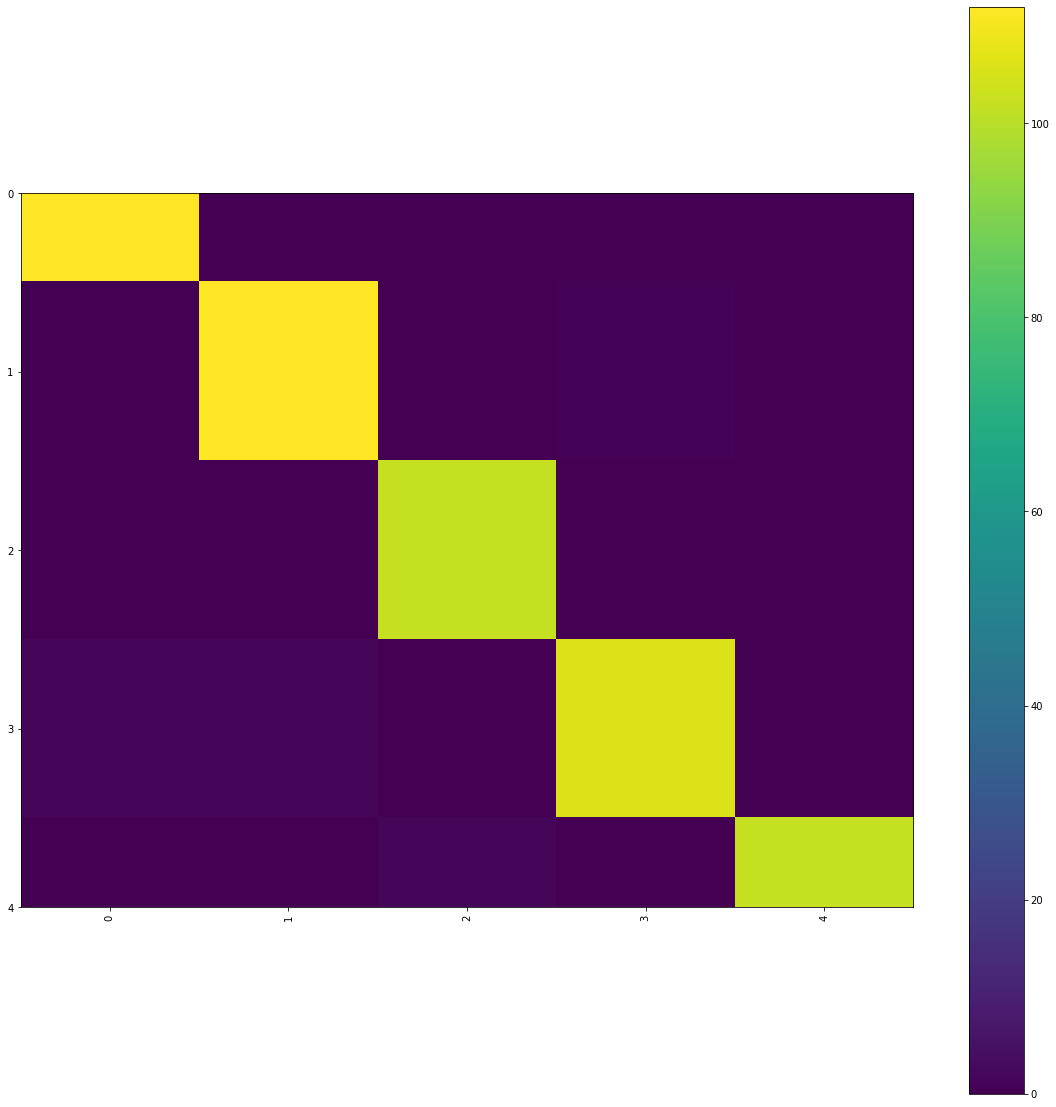

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model

# Matrice de confution et rapport de classification
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)